In [2]:
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# plotting style
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# default figure size
sns.mpl.rc("figure", figsize = (16, 6))
sns.mpl.rc("font", size = 14)

%matplotlib inline

# data

In [4]:
data = pdr.get_data_fred("HOUSTNSA", "1959-01-01", "2019-06-01")
data

,HOUSTNSA
DATE,
1959-01-01,96.2
1959-02-01,99.0
1959-03-01,127.7
1959-04-01,150.8
1959-05-01,152.5
...,...
2019-02-01,80.0
2019-03-01,98.2
2019-04-01,116.6


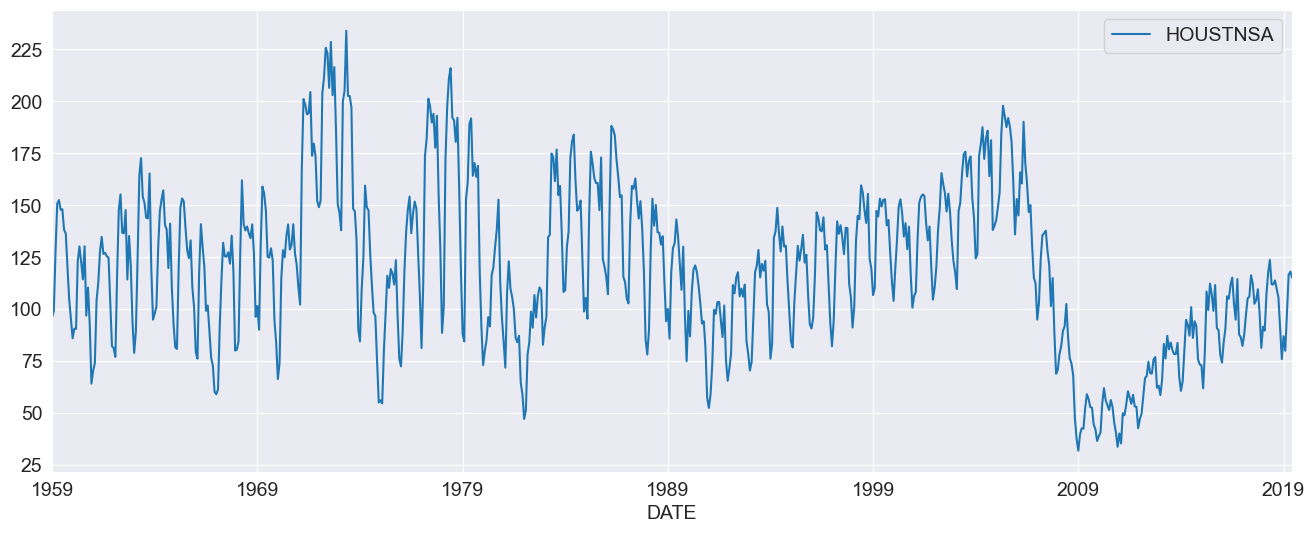

In [5]:
fig, ax = plt.subplots()
ax = data.plot(ax = ax)

# data process

In [6]:
housing = data.HOUSTNSA.pct_change().dropna()
housing = 100 * housing.asfreq("MS")
housing

DATE
1959-02-01     2.910603
1959-03-01    28.989899
1959-04-01    18.089272
1959-05-01     1.127321
1959-06-01    -3.081967
                ...    
2019-02-01    -8.045977
2019-03-01    22.750000
2019-04-01    18.737271
2019-05-01     1.286449
2019-06-01    -2.540220
Freq: MS, Name: HOUSTNSA, Length: 725, dtype: float64

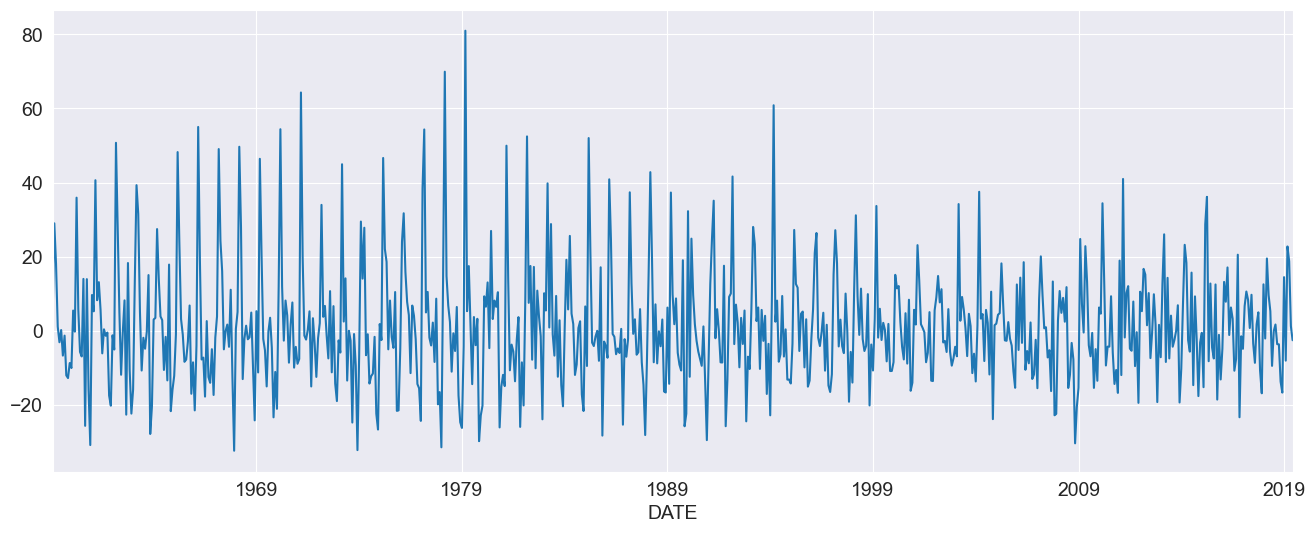

In [7]:
fig, ax = plt.subplots()
ax = housing.plot(ax = ax)

# AR(3)

In [8]:
model = AutoReg(housing, 3, old_names = False)

## 默认 estimator

In [9]:
result = model.fit()
print(result.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  725
Model:                     AutoReg(3)   Log Likelihood               -2993.442
Method:               Conditional MLE   S.D. of innovations             15.289
Date:                Sun, 20 Oct 2024   AIC                           5996.884
Time:                        22:03:48   BIC                           6019.794
Sample:                    05-01-1959   HQIC                          6005.727
                         - 06-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.1228      0.573      1.961      0.050       0.000       2.245
HOUSTNSA.L1     0.1910      0.036      5.235      0.000       0.120       0.263
HOUSTNSA.L2     0.0058      0.037      0.155    

## covariance estimators OLS-HC0

In [10]:
result = model.fit(cov_type = "HC0")
print(result.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  725
Model:                     AutoReg(3)   Log Likelihood               -2993.442
Method:               Conditional MLE   S.D. of innovations             15.289
Date:                Sun, 20 Oct 2024   AIC                           5996.884
Time:                        22:03:49   BIC                           6019.794
Sample:                    05-01-1959   HQIC                          6005.727
                         - 06-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.1228      0.601      1.869      0.062      -0.055       2.300
HOUSTNSA.L1     0.1910      0.035      5.499      0.000       0.123       0.259
HOUSTNSA.L2     0.0058      0.039      0.150    

# ar_select_order

In [11]:
sel = ar_select_order(housing, 13, old_names = False)
print(sel.ar_lags)
result = sel.model.fit()
print(result.summary())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  725
Model:                    AutoReg(13)   Log Likelihood               -2676.157
Method:               Conditional MLE   S.D. of innovations             10.378
Date:                Sun, 20 Oct 2024   AIC                           5382.314
Time:                        22:03:50   BIC                           5450.835
Sample:                    03-01-1960   HQIC                          5408.781
                         - 06-01-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.3615      0.458      2.970      0.003       0.463       2.260
HOUSTNSA.L1     -0.2900      0.036     -8.161      0.000      -0.360      -0.220


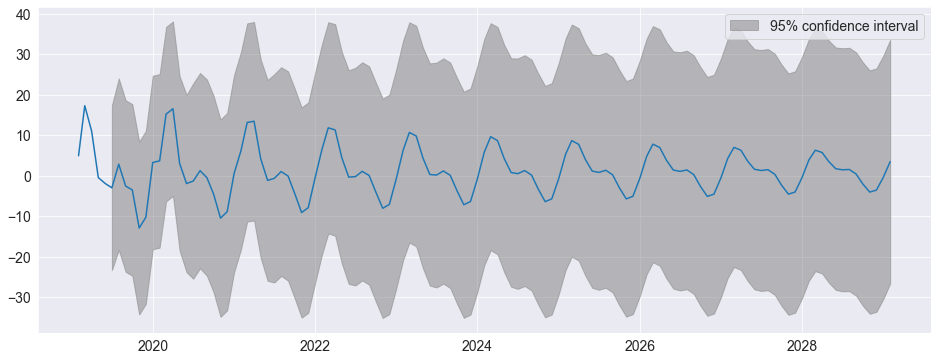

In [11]:
fig = result.plot_predict(720, 840)

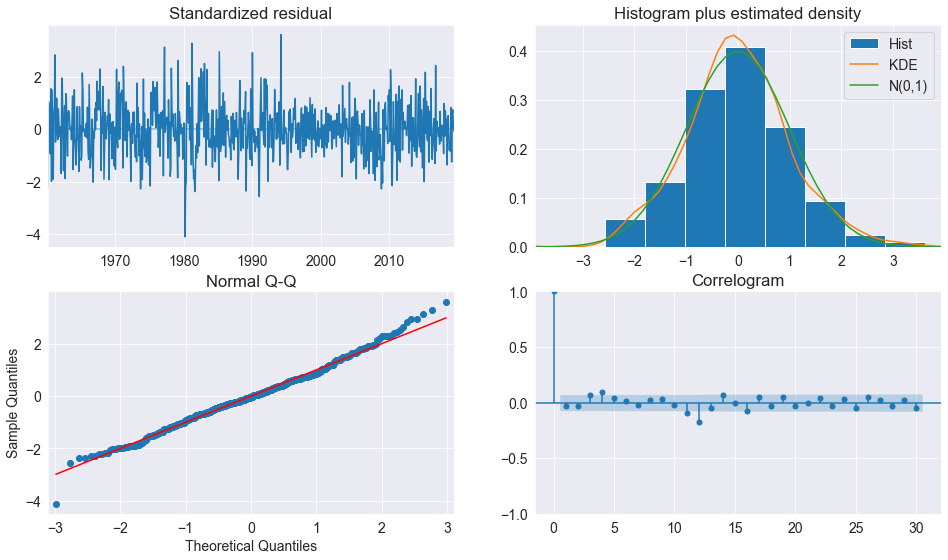

In [12]:
fig = plt.figure(figsize = (16, 9))
fig = result.plot_diagnostics(fig = fig, lags= 30)

# Seasonal Dummies

In [14]:
sel = ar_select_order(housing, 13, seasonal = True, old_names = False)
sel.ar_lags
result = sel.model.fit()
print(result.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  725
Model:               Seas. AutoReg(2)   Log Likelihood               -2652.556
Method:               Conditional MLE   S.D. of innovations              9.487
Date:                Sat, 19 Nov 2022   AIC                           5335.112
Time:                        19:05:16   BIC                           5403.863
Sample:                    04-01-1959   HQIC                          5361.648
                         - 06-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.2726      1.373      0.927      0.354      -1.418       3.963
s(2,12)        32.6477      1.824     17.901      0.000      29.073      36.222
s(3,12)        23.0685      2.435      9.472    

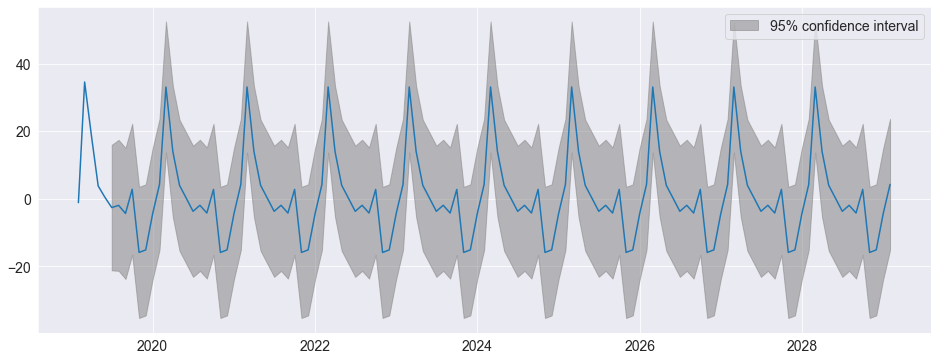

In [16]:
fig = result.plot_predict(720, 840)

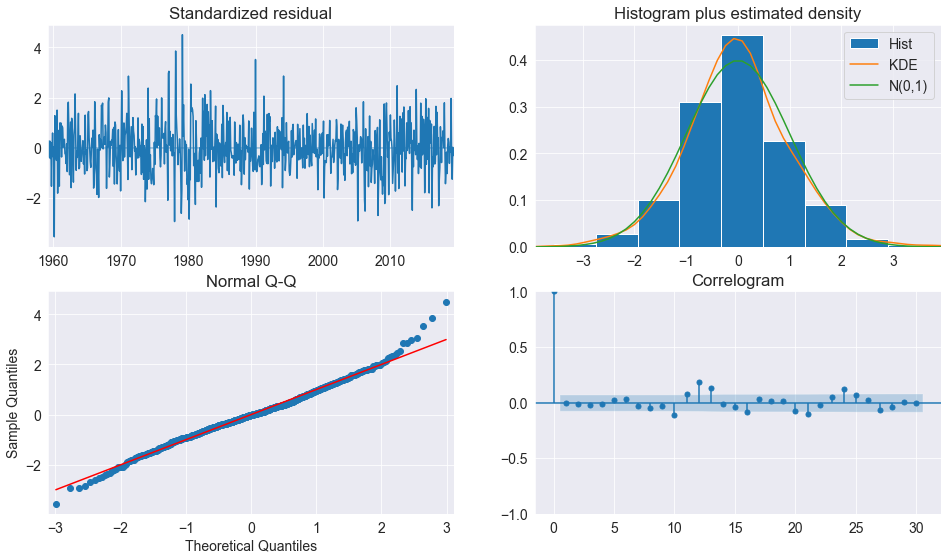

In [17]:
fig = plt.figure(figsize = (16, 9))
fig = result.plot_diagnostics(lags = 30, fig = fig)

# Seasonal Dynamics

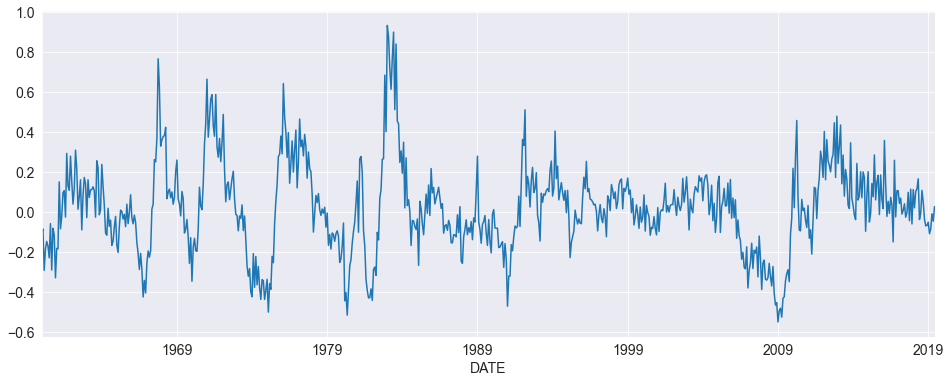

In [18]:
yoy_housing = data.HOUSTNSA.pct_change(12).resample("MS").last().dropna()
_, ax = plt.subplots()
ax = yoy_housing.plot(ax = ax)

In [19]:
sel = ar_select_order(yoy_housing, 13, old_names = False)
sel.ar_lags

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]